<a href="https://colab.research.google.com/github/varamba/Ya_practicum_projects/blob/main/project_sales_funnel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Введение

Необходимо провести аналитику в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи их мобильного приложения, изучите воронку продаж.

Нужно узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах.

После этого нуэно исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении.

Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Надо выяснить, какой шрифт лучше.

## Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as mth
from scipy import stats as st
import datetime as dt
from pandas.plotting import register_matplotlib_converters
from plotly import graph_objects as go
import warnings 
warnings.filterwarnings("ignore")

In [2]:
path = 'https://code.s3.yandex.net/datasets/logs_exp.csv'
df = pd.read_csv(path, sep='\t', engine = 'python')

In [3]:
display(df.head(15))
display(df.describe())
display(df.info())
print('Дупликатов:', df.duplicated().sum())
display(df.isna().sum())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Дупликатов: 413


EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Поменяем названия и формат данных.

In [4]:
df = df.rename(
 columns={
'EventName' : 'event',
'DeviceIDHash' : 'id',
'EventTimestamp' : 'date',
'ExpId' : 'group'}
)

In [5]:
df['date'] = pd.to_datetime(df['date'], unit='s')
df['dt'] = df['date'].dt.date
df['dt'] = df['dt'].astype('datetime64')

In [6]:
df.head()

,event,id,date,group,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Удалим дупликаты.

In [7]:
df = df.drop_duplicates().reset_index(drop=True)

In [8]:
#check
display(df.duplicated().sum())

0

Пропусков нет, дупликаты удалены, форматы поправлены, колонки переименованы.

## Проверка данных

In [9]:
#Количесво событий в логах
df.event.count()

243713

In [10]:
#Количество пользователей
print('Всего участвовало пользователей:', df['id'].nunique())

Всего участвовало пользователей: 7551


Посмотрим какие есть ивенты и проверим количество групп.

In [11]:
df['event'].unique().tolist()

['MainScreenAppear',
 'PaymentScreenSuccessful',
 'CartScreenAppear',
 'OffersScreenAppear',
 'Tutorial']

Видим 5 разных событий.

In [12]:
df['group'].unique().tolist()

[246, 248, 247]

Все сходится, должно быть 3 группы.

In [13]:
#поменяю значения, пусть 1 и 2 - контрольные группы, 3 - экспериментаьная
df.group.replace([246, 247,248], [1, 2, 3], inplace=True)

In [14]:
#check
display(df['group'].unique().tolist())
display(df.head(10))

[1, 3, 2]

,event,id,date,group,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,3,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,3,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,3,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,3,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,1,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,1,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,2,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,1,2019-07-26


In [15]:
#глянем на количество событий в группах
display(df.groupby('group')['group'].agg('count'))

group
1    80181
2    77950
3    85582
Name: group, dtype: int64

In [16]:
#глянем на количество уникальных пользователей в группах
display(df.groupby('group')['id'].agg('nunique'))

group
1    2489
2    2520
3    2542
Name: id, dtype: int64

Количество пользователей в каждой группе примерно одно и то же, значит тест проведен корректно, какой-то выделившейся группы нет.

Так же глянем на среднее число событий на пользователя.

In [17]:
avg=df.event.count()/df['id'].nunique()
avg.round()

32.0

### Период данных

In [18]:
print(f"Полный период: {df['date'].min()} : {df['date'].max()}")

Полный период: 2019-07-25 04:43:36 : 2019-08-07 21:15:17


In [19]:
print(f"Всего: {df['date'].max() - df['date'].min()}")

Всего: 13 days 16:31:41


Построим гистограмму

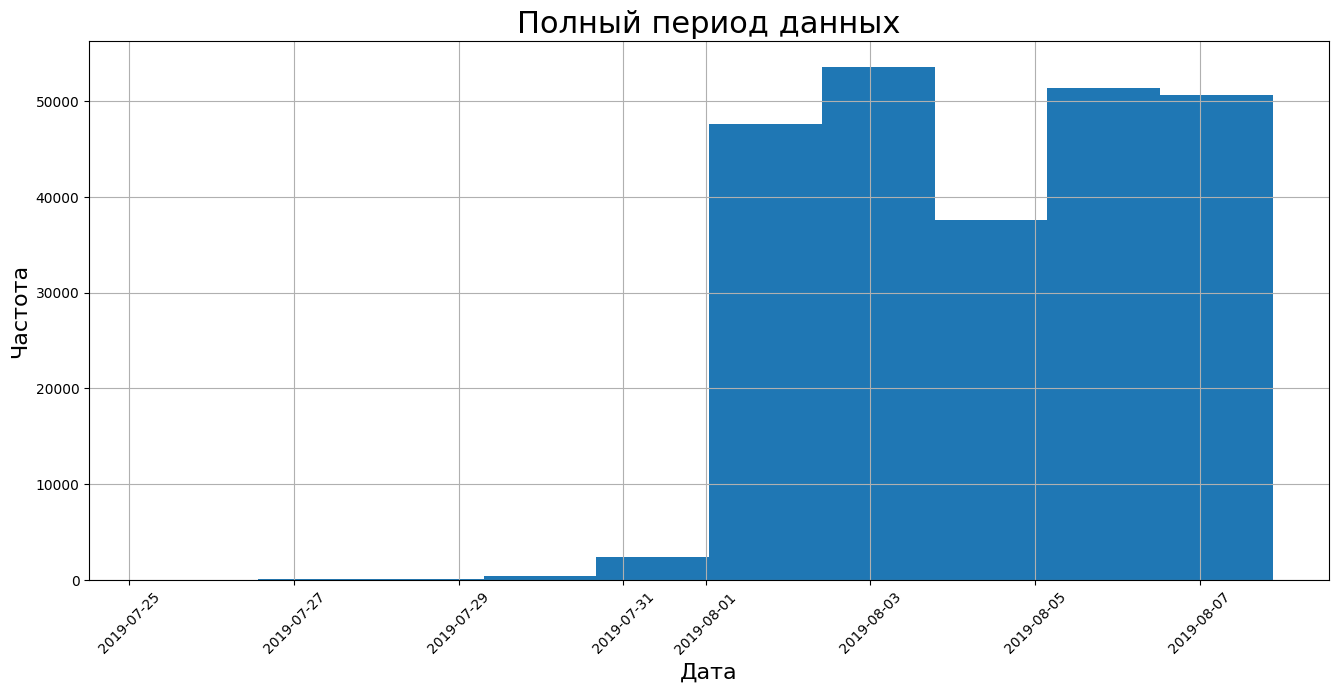

In [20]:
plt.figure(figsize=(16,7))
ax = df['date'].hist()
plt.title('Полный период данных', fontsize=22)
plt.ylabel("Частота", fontsize=16)
plt.xlabel("Дата", fontsize=16)
plt.xticks(rotation=45)
plt.show()

Видим, что с 25 июня по 31 июня данных почти нет, значит их можно удалить.

In [21]:
df_copy = df.copy()

In [22]:
df = df[df['dt'] > '2019-07-31']

In [23]:
print('Стало пользователей:', df['id'].nunique())
print('Стало событий:', df.event.count())

Стало пользователей: 7534
Стало событий: 240887


In [24]:
#Потери
print('Потеряно пользователей: ', df_copy['id'].nunique()-df['id'].nunique())
print('Потеряно событий: ', df_copy.event.count()-df.event.count())
print('Потери пользователей в %:', round(((df_copy['id'].nunique()-df['id'].nunique())/df_copy['id'].nunique()*100),2))
print('Потери событий в %:', ((df_copy['event'].count()-df['event'].count())/df_copy['event'].count()*100).round(2))

Потеряно пользователей:  17
Потеряно событий:  2826
Потери пользователей в %: 0.23
Потери событий в %: 1.16


Потери очень малы, можно исследовать дальше.

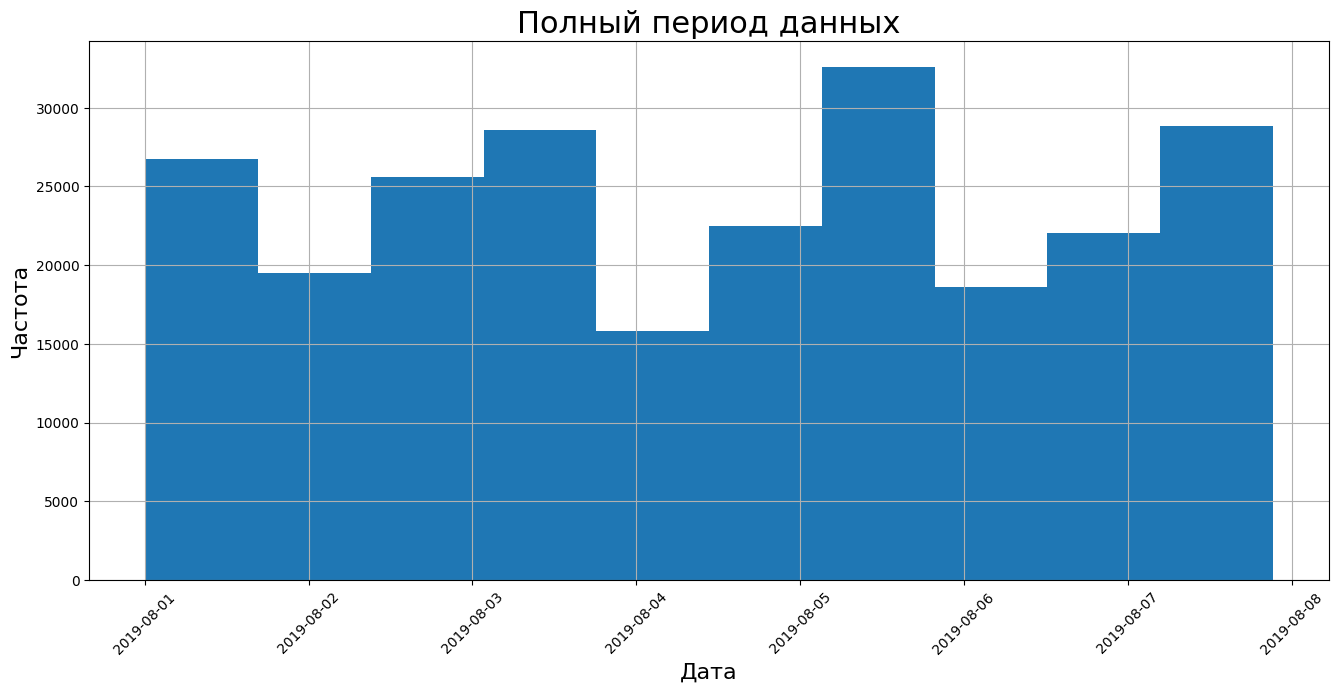

In [25]:
#еще раз построим график
plt.figure(figsize=(16,7))
ax = df['date'].hist()
plt.title('Полный период данных', fontsize=22)
plt.ylabel("Частота", fontsize=16)
plt.xlabel("Дата", fontsize=16)
plt.xticks(rotation=45)
plt.show()

Проверим есть ли пользователи, которые попали в несколько групп.

In [26]:
import functools
from functools import reduce
dups = reduce(np.intersect1d, (df.query('group == 1')['id'].unique(), df.query('group == 2')['id'].unique(), df.query('group == 3')['id'].unique()))

In [27]:
dups

array([], dtype=int64)

Нет совпадения, знаит каждый пользователь попал в одну группу, это хорошо.

#### Вывод

Всего 7551 уникальных пользователей.

Всего событий - 243713.

Период данных: с 25 июня по 8 августа, при этом актуальный период берем с 1 августа.

Потеряно пользователей после актуализации периода:  17

Потеряно событий после актуализации периода:  2826

### Воронка событий

In [28]:
df = df.query('event != "Tutorial"')

In [29]:
df.groupby('event')['event'].count().sort_values(ascending= False)

event
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event, dtype: int64

**Далее:**

- Посчитаем, сколько пользователей совершали каждое из этих событий.

- Отсортируем события по числу пользователей.

- Посчитаем долю пользователей, которые хоть раз совершали событие.

In [30]:
funnel = df.groupby('event')['id'].nunique().sort_values(ascending=False).reset_index().rename(columns={'id': 'users'})
funnel['fraction'] = (funnel['users'] / df['id'].nunique() * 100).round()
funnel

,event,users,fraction
0,MainScreenAppear,7419,99.0
1,OffersScreenAppear,4593,61.0
2,CartScreenAppear,3734,50.0
3,PaymentScreenSuccessful,3539,47.0


**Воронка выглядит примерно так:**

Пользователь видит главную страницу

Пользователь видит экран предложений товаров

Пользователь видит корзину

Пользователь видит экран успешной оплаты

Пользователь видит некую инструкцию (возможно как забрать товар из пункта или как оставить отзыв, по всей видимости это не очень популярная штука, тк товар уже куплен и этот шаг люди пропускают)

*В проекте не объясняется что есть что, так что это мой вольный перевод.

Также подметим, что 2% польщователей не попадают даже на главную страницу, что очень странно.

Причина может быть в нестабильности приложения - вылетает, либо пользователь зарегистрировался, но не стал польщоваться приложением.

**Посчитаем доли отвалившихся клиентов на этапах воронки.**

In [31]:
fig = go.Figure(go.Funnel(
    y = funnel['event'],
    x = funnel['users'],
    textposition = "inside",
    textinfo = "value+percent initial",
    opacity = 0.65, marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal", "silver"],
    "line": {"width": [3, 3, 3, 3, 3, 3], "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}})
    )

fig.show()

Для пользователей из всех групп видим, что до оплаты доходит 48%, а до туториала(чтобы это ни было) всего 11%.

In [32]:
#df = df.query('event != "Tutorial"')

Посчитаем воронки для пользователей по группам.

In [33]:
df.head()

,event,id,date,group,dt
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,1,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,1,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,1,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,2,2019-08-01
2831,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,2,2019-08-01


In [34]:
funnel_grouped = df.groupby(['group', 'event'])['id'].nunique().reset_index().rename(columns={'id': 'users'})
funnel_grouped

,group,event,users
0,1,CartScreenAppear,1266
1,1,MainScreenAppear,2450
2,1,OffersScreenAppear,1542
3,1,PaymentScreenSuccessful,1200
4,2,CartScreenAppear,1238
5,2,MainScreenAppear,2476
6,2,OffersScreenAppear,1520
7,2,PaymentScreenSuccessful,1158
8,3,CartScreenAppear,1230
9,3,MainScreenAppear,2493


In [35]:
funnel_1 = funnel_grouped.query('group == 1').reset_index().sort_values(by = 'users', ascending = False)
funnel_1

,index,group,event,users
1,1,1,MainScreenAppear,2450
2,2,1,OffersScreenAppear,1542
0,0,1,CartScreenAppear,1266
3,3,1,PaymentScreenSuccessful,1200


In [36]:
funnel_2 = funnel_grouped.query('group == 2').reset_index().sort_values(by = 'users', ascending = False)
funnel_2

,index,group,event,users
1,5,2,MainScreenAppear,2476
2,6,2,OffersScreenAppear,1520
0,4,2,CartScreenAppear,1238
3,7,2,PaymentScreenSuccessful,1158


In [37]:
funnel_3 = funnel_grouped.query('group == 3').reset_index().sort_values(by = 'users', ascending = False)
funnel_3

,index,group,event,users
1,9,3,MainScreenAppear,2493
2,10,3,OffersScreenAppear,1531
0,8,3,CartScreenAppear,1230
3,11,3,PaymentScreenSuccessful,1181


Покажем воронки на графике.

In [38]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Group 1',
    y = funnel_1['event'],
    x = funnel_1['users'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 2',
    orientation = "h",
    y = funnel_2['event'],
    x = funnel_2['users'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Group 3',
    orientation = "h",
    y = funnel_3['event'],
    x = funnel_3['users'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.show()

Картина для каждой группы примерно одинаковая:

До второго шага доходит только 61-63% пользователей, а до оплаты только 47%.

Больше всего теряется на 2м шаге, не считая туториала.

Так же если пользователь добавил товар в корзину, то он его скорее всего покупает.

## Проверка результатов эксперимента

Критерии успешного A/A теста:

Количество пользователей в различных группах различается не более, чем на 1%;

Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же;

Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;

Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

Ранее мы уже проверили, что нет пользователей попавших в разные группы.

Проверим разницу в количестве:

In [39]:
print('Разница между 1й и 2й группой:', round(((1 - df.query('group == 1')['id'].nunique()/df.query('group == 2')['id'].nunique())*100), 2), '%')

Разница между 1й и 2й группой: 1.15 %


Я думаю можем считать что разница очень мала, хоть она и немного больше 1%.

По хорошему разница должна быть меньше 1%, а то и 0.5%, но в рамках проекта мы не можем отменить тест, поэтому Считаем, что группы идентичны.

Какие данные отсылают мы не можем проверить. Значит верим источнику.

Проверим различия метрик:

In [40]:
df_gr = df.pivot_table(index='event', columns='group', values='id', aggfunc='nunique', margins = True).reset_index().sort_values('All', ascending=False).reset_index(drop=True)
df_gr['1-2'] = df_gr[1] + df_gr[2]
df_gr = df_gr.reindex([1, 2, 3, 4, 0]).reset_index(drop=True)
df_gr

group,event,1,2,3,All,1-2
0,MainScreenAppear,2450,2476,2493,7419,4926
1,OffersScreenAppear,1542,1520,1531,4593,3062
2,CartScreenAppear,1266,1238,1230,3734,2504
3,PaymentScreenSuccessful,1200,1158,1181,3539,2358
4,All,2483,2512,2535,7530,4995


In [41]:
def check_metrics(i, g1, g2): 
    alpha = 0.01
    u1 = df_gr.loc[i][g1]
    u2 = df_gr.loc[i][g2]
    e1 = df_gr.loc[4][g1]
    e2 = df_gr.loc[4][g2]

    
    # пропорция успехов в первой группе:
    p1 = u1 / e1
    # пропорция успехов во второй группе
    p2 = u2 / e2
    
    # пропорция успехов в комбинированном датасете
    p_c = (u1 + u2) / (e1 + e2) 
    
    # разница пропорций в датасетах
    diff = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = diff / mth.sqrt(p_c * (1 - p_c) * (1 / e1 + 1 / e2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # введем поправку Бонферрони, поделим альфа на число гипотез для всех проверок
    bonferroni_alpha = alpha / 16
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(g1, g2, i, p_value=p_value))
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу о равенстве данных в группах")
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах")


Сравним группы 1 и 2:

Н0: доли уникальных посетителей, находящихся в группах 1 и 2, побывавших на этапе воронки, одинаковы.

Н1: доли уникальных посетителей, побывавших на этапе воронки, различаются.

In [42]:
for event in range(len(df_gr.index[:-1])):
    check_metrics(event,1,2)

Проверка для групп 1 и 2, событие: 0, p-значение: 0.75
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 2, событие: 1, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 2, событие: 2, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 2, событие: 3, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах


Сравним группы 1 и 3:

Н0: доли уникальных посетителей, находящихся в группах 1 и 3, побывавших на этапе воронки, одинаковы.

Н1: доли уникальных посетителей, побывавших на этапе воронки, различаются.

In [43]:
for event in range(len(df_gr.index[:-1])):
    check_metrics(event,1,3)

Проверка для групп 1 и 3, событие: 0, p-значение: 0.34
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 3, событие: 1, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 3, событие: 2, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 3, событие: 3, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах


Сравним группы 2 и 3:

Н0: доли уникальных посетителей, находящихся в группах 2 и 3, побывавших на этапе воронки, одинаковы.

Н1: доли уникальных посетителей, побывавших на этапе воронки, различаются.

In [44]:
for event in range(len(df_gr.index[:-1])):
    check_metrics(event,1,3)

Проверка для групп 1 и 3, событие: 0, p-значение: 0.34
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 3, событие: 1, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 3, событие: 2, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1 и 3, событие: 3, p-значение: 0.22
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах


Сравним группы 1-2 и 3:

Н0: доли уникальных посетителей, находящихся в группах 1-2 и 3, побывавших на этапе воронки, одинаковы.

Н1: доли уникальных посетителей, побывавших на этапе воронки, различаются.

In [45]:
for event in range(len(df_gr.index[:-1])):
    check_metrics(event,'1-2',3)

Проверка для групп 1-2 и 3, событие: 0, p-значение: 0.35
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1-2 и 3, событие: 1, p-значение: 0.45
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1-2 и 3, событие: 2, p-значение: 0.19
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
Проверка для групп 1-2 и 3, событие: 3, p-значение: 0.61
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах


**Вывод:** Нет статистически значимой разницы для всех событий между всеми группами.

## Вывод

В ходе задания был проведен анализ А/В теста приложения.

При обработке данных была проведена предобработка данных, в которой был выявлен актуальный период проведения теста: с 1 августа по 8 августа.

В тесте были такие показатели(в актуальном временном периоде):

Было 7534 уникальных пользователей и 240887 событий.

Далее была определена воронка событий, до последнего шага которой доходит 48% пользователей, а больеш всего отваливается на 2м шаге - 38%.

При этом 2% даже не заходят на главную страницу.

Далее был проведен анализ теста:
- Группы для А/А/В-тестов были не совсем корректными, тк была разница в  1.15% количества пользователей между группами 1 и 2, что больше необходимого 1%.
- При проверке статистических гипотез уровень значимости альфа был 1%.
- Так как было преведено 16 сравнений, то была сделана поправка Бонферрони.
- Несмотря на некорректность групп статистически значимой разницы между группами во всех тестах выявлено не было.

Значит изменение шрифта не дало результатов.